## Enhancing performance using GPGPU
In the 90s and 2000s, graphics hardware was designed to cater to specific needs, especially for workloads in the graphics industry. But graphics workloads demanded increasing computing power. Graphics hardware was increasing performance at more than 2.4 times per year, faster than Moore’s law predicted. NVIDIA graphics processing units (GPUs) were originally designed for running games and graphics workloads that were highly parallel in nature. Because of high demand for FLOPS and memory bandwidth in the gaming and graphics industry, GPUs evolved into a highly parallel, multithreaded, manycore processor with enormous computational horsepower and high memory bandwidth. This started the era of GPGPU:  general purpose computing on GPUs that were originally designed to accelerate only specific workloads like gaming and graphics. 

<center>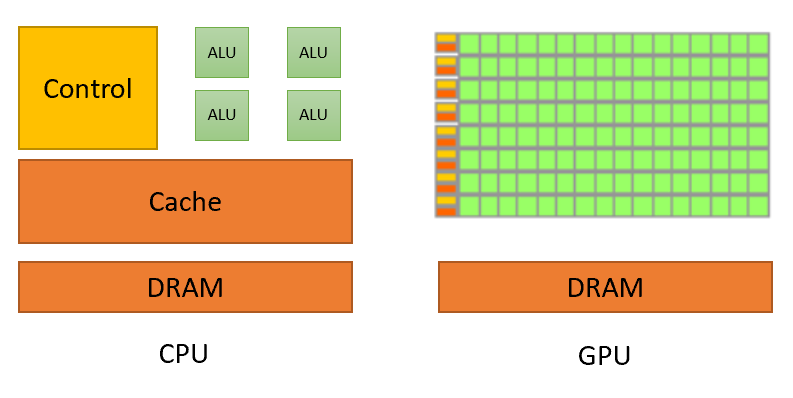</center>
<center>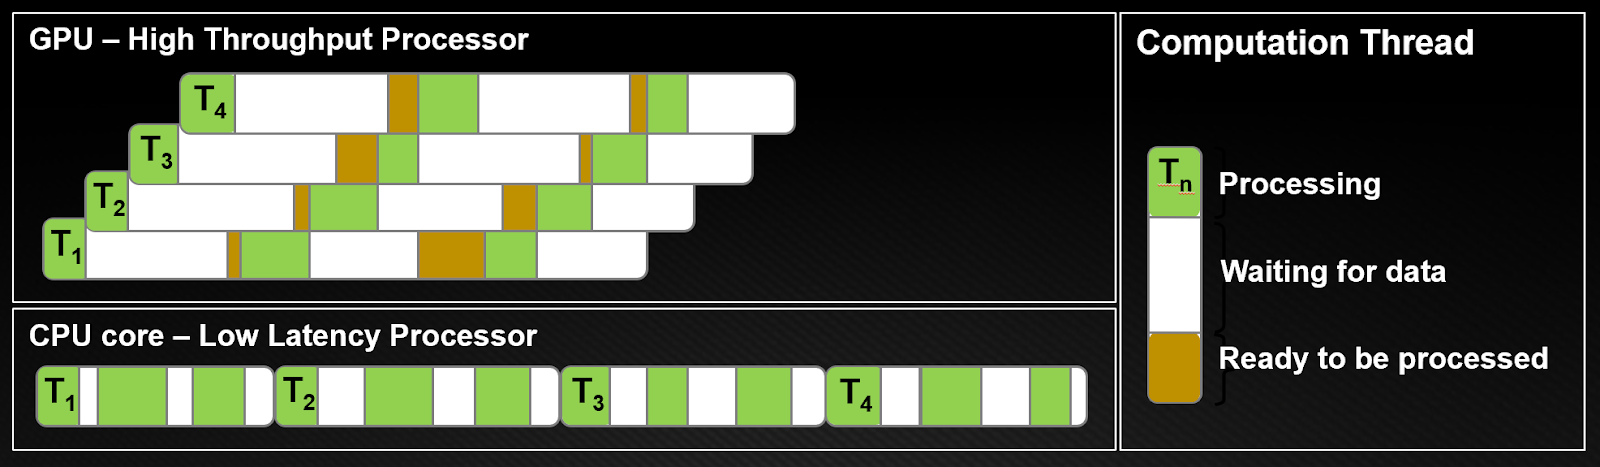</center>
<center>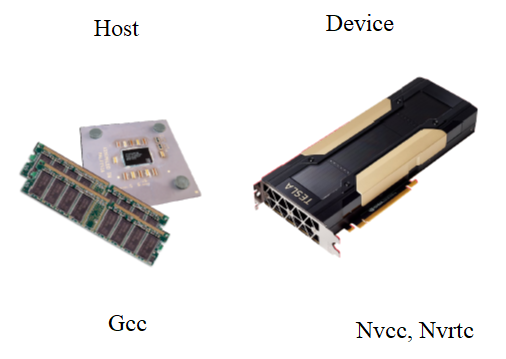</center>

<div align="center"> source: https://developer.nvidia.com/blog/cuda-refresher-reviewing-the-origins-of-gpu-computing/ </div>

GPUs dedicate most of their transistors for data processing while CPUs also need to reserve die area for big caches, control units, and so on. CPU processors work on the principle of minimizing latency within each thread while GPUs hide the instruction and memory latencies with computation. Figure 3 shows the difference in computation threads. 

## Using `Numba`
`Numba` supports CUDA GPU programming by directly compiling a restricted subset of Python code into CUDA kernels and device functions following the CUDA execution model. Kernels written in Numba appear to have direct access to NumPy arrays. NumPy arrays are transferred between the CPU and the GPU automatically.

In [1]:
#import os
#os.environ['NUMBA_ENABLE_CUDASIM'] = '1'
from numba import cuda
import numba as nb
import numpy as np
import math

In [2]:
print(cuda.gpus)

<Managed Device 0>


If your machine has multiple GPUs, you might want to select which one to use

In [3]:
nb.cuda.select_device(0)

<weakproxy at 0x00000224BF596950 to Device at 0x00000224BCED09A0>

Using the CUDA simulator

If you don’t have a CUDA-enabled GPU (i.e. you received one of the error messages described previously), then you will need to use the CUDA simulator. The simulator is enabled by setting the environment variable NUMBA_ENABLE_CUDASIM to 1.

- Mac/Linux: Launch a terminal shell and type the commands:
`export NUMBA_ENABLE_CUDASIM=1`

- Windows: Launch a CMD shell and type the commands:
`SET NUMBA_ENABLE_CUDASIM=1`

### Kernel
CUDA kernel is a function that gets executed on GPU. The parallel portion of your applications is executed K times in parallel by K different CUDA threads.
CUDA defines built-in 3D variables for threads and blocks.Three-dimensional indexing provides a natural way to index elements in vectors, matrix, and volume and makes CUDA programming easier

- kernels cannot explicitly return a value; all result data must be written to an array passed to the function (if computing a scalar, you will probably pass a one-element array);
- kernels explicitly declare their thread hierarchy when called: i.e. the number of thread blocks and the number of threads per block (note that while a kernel is compiled once, it can be called multiple times with different block sizes or grid sizes).

<center>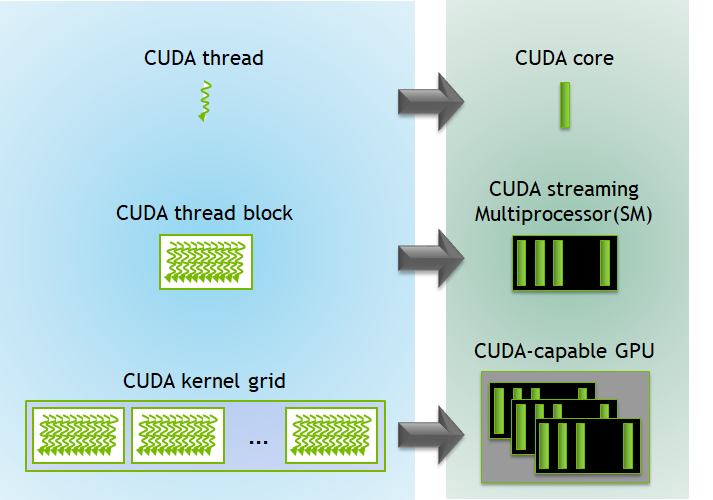</center>

<div align="center"> source: https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/ </div>

When running, the kernel function’s code is executed by every thread once. It therefore has to know which thread it is in, in order to know which array element(s) it is responsible for. In programming, one way is determines the thread position in the grid and block and manually compute the corresponding array position:

In [4]:
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < io_array.size:  # Check array boundaries
        io_array[pos] *= 2 # do the computation

Numba provides additional facilities to automate such calculations:

- `numba.cuda.grid(ndim)` - Return the absolute position of the current thread in the entire grid of blocks. ndim should correspond to the number of dimensions declared when instantiating the kernel. If `ndim` is 1, a single integer is returned. If `ndim` is 2 or 3, a tuple of the given number of integers is returned.
- `numba.cuda.gridsize(ndim)` - Return the absolute size (or shape) in threads of the entire grid of blocks. ndim has the same meaning as in `grid()` above.

In [5]:
@cuda.jit
def my_kernel2(io_array):
    pos = cuda.grid(1)
    if pos < io_array.size:
        io_array[pos] *= 2 # do the computation

In [6]:
# Host code   
data = np.ones(256)
threadsperblock = 256
blockspergrid = math.ceil(data.shape[0] / threadsperblock)
my_kernel2[blockspergrid, threadsperblock](data)
data

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.

For 2D data the index is similar

In [7]:
@cuda.jit
def my_kernel_2D(io_array):
    x, y = cuda.grid(2)
    if x < io_array.shape[0] and y < io_array.shape[1]:
        io_array[x, y] *= 2 # do the computation
        
data = np.ones((16, 16))
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(data.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(data.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)
my_kernel_2D[blockspergrid, threadsperblock](data)
data

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,

### Matrix multiplication
Each thread reads one row of A and one column of B and computes the corresponding element of C. For input arrays where A.shape == (m, n) and B.shape == (n, p) then the result shape will be C.shape = (m, p).

<center>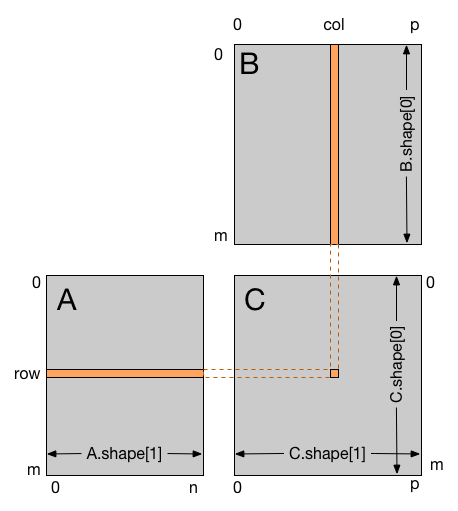</center>

<div align="center"> source: https://nyu-cds.github.io/python-numba/05-cuda/ </div>

There are two main steps:

- Instantiate the kernel proper, by specifying a number of blocks per grid and a number of threads per block. The product of the two will give the total number of threads launched. Kernel instantiation is done by taking the compiled kernel function and indexing it with a tuple of integers.
- Running the kernel, by passing it the input array (and any separate output arrays if necessary). By default, running a kernel is synchronous: the function returns when the kernel has finished executing and the data is synchronized back.

- Data is copied from the CPU (host) to the GPU (device), where it is computed on. After a computation, it need to be copied back to the CPU to be interacted with by numpy, etc

In [8]:
# CUDA kernel
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

In [9]:
# Host code

# Numba has been automatically transferring the NumPy arrays to the device when you invoke the kernel.
# Initialize the data arrays
A = np.full((24, 12), 3, np.float) # matrix containing all 3's
B = np.full((12, 22), 4, np.float) # matrix containing all 4's
C = np.empty((24,22), np.float)

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Start the kernel 
matmul[blockspergrid, threadsperblock](A, B, C)

C

Wall time: 799 ms


array([[144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.],
       [144., 144., 144., 144., 144., 144., 144., 144., 144., 144., 144.,
        144., 144., 144., 144., 

- Check share memory https://nyu-cds.github.io/python-numba/05-cuda/ and https://numba.pydata.org/numba-doc/dev/cuda/examples.html
    

## Using `CuPy`
Simply put: `CuPy` is `NumPy`, but for the GPU. Preferred Networks created CuPy as the GPU backend for their deep learning library, Chainer, but it also works great as a standalone NumPy-like GPU array library. If you know NumPy, CuPy is a very easy way to get started on the GPU.

CuPy also includes the following features for performance:

- User-defined elementwise CUDA kernels
- Includes frequently used functions from `SciPy`. 


In [3]:
from cupy.cuda import nvrtc
import cupy as cp
nvrtc.getVersion()

(11, 0)

### RawKernel

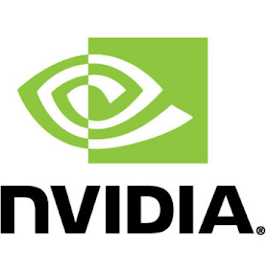

In [32]:
from PIL import Image
logo_img = Image.open('../LOGO.png') #source: https://seeklogo.com/vector-logo/101614/nvidia

from IPython.display import display
display(logo_img)

In [34]:
(r, g, b) = logo_img.split()

r_array = np.array(r)
g_array = np.array(g)
b_array = np.array(b)
logo_array = np.stack((r_array, g_array, b_array))

In [35]:
in_gpu_array = cp.array(logo_array)
out_gpu_array = cp.empty_like(in_gpu_array)

In [36]:
img_add_const_value_kernel = cp.RawKernel(r'''
    extern "C" __global__
    void img_add_const_value(unsigned char* dst, unsigned char* src, int w, int h, int v) {
        int x = blockIdx.x * blockDim.x + threadIdx.x;
        int y = blockIdx.y * blockDim.y + threadIdx.y;
        int z = blockIdx.z * blockDim.z + threadIdx.z;
        if (x < w && y < h) {
            src += w * h * z;
            dst += w * h * z;
            int pos = y * w + x;
            int tmp = (int)src[pos] + v;
            tmp = (tmp > 255) ? 255:tmp;
            tmp = (tmp <   0) ?   0:tmp;
            dst[pos] = tmp;
        }
    }
    ''', 'img_add_const_value')

In [37]:
(c, h, w) = in_gpu_array.shape
block = (16, 16, 1)
grid = ((w + 15)//16, (h + 15)//16, c)
img_add_const_value_kernel(grid, block, (out_gpu_array, in_gpu_array, w, h, 50))

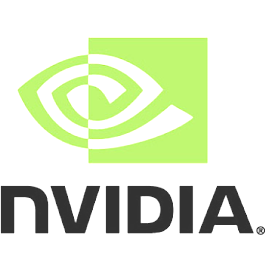

In [38]:
out_logo_array = cp.asnumpy(out_gpu_array)

r_img = Image.fromarray(out_logo_array[0,:,:])
g_img = Image.fromarray(out_logo_array[1,:,:])
b_img = Image.fromarray(out_logo_array[2,:,:])

out_img = Image.merge('RGB', (r_img, g_img, b_img))
display(out_img)

### Array oriented programming

In [48]:
cp.cuda.Device(0).use()
x_gpu = cp.arange(1000)
x_cpu = np.arange(1000)

In [51]:
np.linalg.norm(x_cpu)

18243.72494859534

In [52]:
cp.linalg.norm(x_gpu)

array(18243.7249486)

In [3]:
m = 1000
n = 1000
p = 100

X1 = np.random.random((m, p))
Y1 = np.random.random((p, n))

X2 = cp.random.random((m, p))
Y2 = cp.random.random((p, n))

In [4]:
%timeit X1.dot(Y1)

4.2 ms ± 56.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
%timeit X2.dot(Y2)

The slowest run took 4.80 times longer than the fastest. This could mean that an intermediate result is being cached.
15 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


MonteCarlo

In [6]:
def monte_carlo_pi(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

def monte_carlo_pi_cp(n):
    x = cp.random.uniform(-1, 1, (n,2))
    return 4*cp.sum((x**2).sum(1) < 1)/n

In [7]:
%%timeit
[monte_carlo_pi(int(1e7)) for i in range(10)]

3.75 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
[monte_carlo_pi_cp(int(1e7)) for i in range(10)]

1.85 ms ± 45.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


GPU spedup functions are optimized for at least four things: 

- Input size 
- Compute complexity 
- CPU/GPU copying 
- Data type. 

Concretely, a gpu spedup function can be slow because the input size is too small, the computation is too simple, there is excessive data copying to/from GPU/CPU, and the input types matters.

## Laboratories

In [4]:
# Baseline
def cdist(xs, ys):
    """Returns pairwise distance between row vectors in xs and ys.
    
    xs has shape (m, p)
    ys has shape (n, p)
    
    Return value has shape (m, n)    
    """
    
    m, p = xs.shape
    n, p = ys.shape
    
    res = np.empty((m, n))
    for i in range(m):
        for j in range(n):
            res[i, j] = np.sqrt(np.sum((ys[j] - xs[i])**2))
    return res

In [5]:
m = 1000
n = 1000
p = 100

X = np.random.random((m, p))
Y = np.random.random((n, p))

In [6]:
Z = cdist(X, Y)
Z

array([[3.637979  , 4.08117235, 3.87334034, ..., 4.17141528, 3.92658498,
        3.96776237],
       [3.78460153, 3.98613868, 3.89886628, ..., 4.39445538, 3.96968959,
        4.23636347],
       [3.96413469, 3.88401982, 4.11764641, ..., 4.00880108, 3.78941294,
        4.02244403],
       ...,
       [4.42279775, 4.05391356, 4.19918568, ..., 4.1937755 , 4.38978232,
        3.95982578],
       [4.10178038, 4.36835161, 3.82245008, ..., 4.4781301 , 4.19422113,
        3.96822937],
       [3.71419995, 4.00721069, 4.38855173, ..., 4.23169185, 4.16754162,
        4.09206833]])

In [7]:
%%timeit
Z = cdist(X, Y)

6.95 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using `CuPy`

In [8]:
# Baseline
def cdist_cupy(xs, ys):
    """Returns pairwise distance between row vectors in xs and ys.
    
    xs has shape (m, p)
    ys has shape (n, p)
    
    Return value has shape (m, n)    
    """
    
    m, p = xs.shape
    n, p = ys.shape
    
    res = cp.empty((m, n))
    for i in range(m):
        for j in range(n):
            #res[i, j] = cp.linalg.norm(ys[j] - xs[i])
            res[i, j] = cp.sqrt(cp.sum((ys[j] - xs[i])**2))
    return res

In [9]:
m = 1000
n = 1000
p = 100

#X2 = cp.random.random((m, p))
#Y2 = cp.random.random((n, p))
X2 = cp.asarray(X)
Y2 = cp.asarray(Y)

In [10]:
%%time
Z2 = cdist_cupy(X2, Y2)

Wall time: 1min 46s


In [22]:
np.allclose(Z,Z2)

array(True)

In [11]:
Z3 = np.empty((1000,1000))

In [12]:
%%timeit
for i in range(X.shape[0]):
    Z3[i,:] = np.sqrt(((np.broadcast_to(X[i,:], X.shape) - Y)**2).sum(axis=1))

268 ms ± 7.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
for i in range(X.shape[0]):
    Z3[i,:] = np.linalg.norm((np.broadcast_to(X[i,:], X.shape) - Y), axis=1)

284 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
np.allclose(Z,Z3)

True

In [15]:
Z4 = cp.empty((1000,1000))

In [16]:
%%timeit
for i in range(X2.shape[0]):
    Z4[i,:] = cp.sqrt(((cp.broadcast_to(X2[i,:], X2.shape) - Y2)**2).sum(axis=1))

404 ms ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
for i in range(X2.shape[0]):
    Z4[i,:] = cp.linalg.norm((cp.broadcast_to(X2[i,:], X2.shape) - Y2), axis=1)

82.8 ms ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
np.allclose(Z,Z4)

array(True)

In [18]:
import scipy.spatial

In [19]:
%%timeit
scipy.spatial.distance.cdist(X,Y)

113 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
Z5 = scipy.spatial.distance.cdist(X,Y)

In [24]:
np.allclose(Z,Z5)

True

## Exercise 4: 
- Calculate the pairwise euclidean distance between two matrices X and Y using method you learn in this minicourse and report the speedup over baseline

In [ ]:
## Solution here

In [29]:
from joblib import Parallel, delayed
from numba import jit, njit
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

### Using optimized formula to calculate

In [63]:
## The formula is from https://www.pythonlikeyoumeanit.com/Module3_IntroducingNumpy/Broadcasting.html#The-Final-Answer,-At-Last!
def pairwise_dists(x, y): 
    """ Computing pairwise distances using memory-efficient
    vectorization.

    Parameters
    ----------
    x : numpy.ndarray, shape=(M, D)
    y : numpy.ndarray, shape=(N, D)

    Returns
    -------
    numpy.ndarray, shape=(M, N)
        The Euclidean distance between each pair of
        rows between `x` and `y`."""
    sqr_dists = -2 * np.matmul(x, y.T)
    sqr_dists +=  np.sum(x**2, axis=1)[:, np.newaxis]
    sqr_dists += np.sum(y**2, axis=1)
    return  np.sqrt(np.clip(sqr_dists, a_min=0, a_max=None))

In [27]:
Z6 = pairwise_dists(X,Y)
np.allclose(Z,Z6)

True

In [26]:
%%timeit
Z6 = pairwise_dists(X,Y)

16.7 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


The speedup is 6.95/0.0167~ 416.2 times faster

### Numba + joblib

In [30]:
@njit
def cdist_numba1(xs, ys):
    """Returns pairwise distance between row vectors in xs and ys.
    
    xs has shape (m, p)
    ys has shape (n, p)
    
    Return value has shape (m, n)    
    """
    
    m, p = xs.shape
    n, p = ys.shape
    
    res = np.empty((m, n))
    for i in range(m):
        for j in range(n):
            s = 0
            for k in range(p):
                s += (ys[j,k] - xs[i,k])**2
            res[i, j] = np.sqrt(s)
    return res

In [32]:
Z7 = Parallel(n_jobs=8)(delayed(cdist_numba1)(X_, Y) for X_ in tqdm(np.split(X, 10, 0)))
Z7 = np.concatenate(Z7)

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 5012.91it/s]


In [33]:
np.allclose(Z,Z7)

True

In [34]:
%%timeit
Z7 = Parallel(n_jobs=8)(delayed(cdist_numba1)(X_, Y) for X_ in tqdm(np.split(X, 10, 0)))
Z7 = np.concatenate(Z7)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10034.22it/s]


52.3 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The speedup is 6.95/0.0523~ 132.9 times faster

### Cython+joblib

In [35]:
%load_ext cython

In [36]:
%%cython

import cython
import numpy as np
from libc.math cimport sqrt, pow
from joblib import wrap_non_picklable_objects

@wrap_non_picklable_objects
@cython.boundscheck(False)
@cython.wraparound(False)
def cdist_cython(double[:, :] xs, double[:, :] ys):
    """Returns pairwise distance between row vectors in xs and ys.
    
    xs has shape (m, p)
    ys has shape (n, p)
    
    Return value has shape (m, n)    
    """
    
    cdef int m, n, p
    
    m = xs.shape[0]
    n = ys.shape[0]
    p = xs.shape[1]
    
    cdef double[:, :] res = np.empty((m, n))
    
    cdef int i, j
    
    cdef double s
    with cython.nogil:
        for i in range(m):
            for j in range(n):
                s = 0.0
                for k in range(p):
                    s += pow(ys[j,k] - xs[i,k], 2)                
                res[i, j] = sqrt(s)
    return res

In [38]:
from joblib import parallel_backend
with parallel_backend("threading"):  
    Z8 = Parallel(n_jobs=8)(delayed(cdist_cython)(X_, Y) for X_ in tqdm(np.split(X, 10, 0)))
    Z8 = np.concatenate(Z8)

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2506.01it/s]


In [39]:
np.allclose(Z,Z8)

True

In [40]:
%%timeit
with parallel_backend("threading"):  
    Z8 = Parallel(n_jobs=8)(delayed(cdist_cython)(X_, Y) for X_ in tqdm(np.split(X, 10, 0)))
    Z8 = np.concatenate(Z8)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 626.77it/s]


35 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The speedup is 6.95/0.035~ 198.6 times faster

### CuPy+joblib

In [47]:
def cdist_cupy(X,Y):
    return cp.linalg.norm((cp.broadcast_to(X, X.shape) - Y), axis=1)

In [60]:
Z9 = Parallel(n_jobs=8)(delayed(cdist_cupy)(X2[i,:], Y2) for i in tqdm(range(1000)))
Z9 = np.vstack(Z9)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2977.88it/s]


In [61]:
np.allclose(Z,Z9)

array(True)

In [48]:
%%timeit
Z9 = Parallel(n_jobs=8)(delayed(cdist_cupy)(X2[i,:], Y2) for i in tqdm(range(1000)))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3161.09it/s]


700 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The speedup is 6.95/0.7~ 9.9 times faster

## Referecnes
- https://developer.nvidia.com/blog/tag/cuda-refresher/ - A great review for CUDA programming
- https://nyu-cds.github.io/python-numba/05-cuda/ - A good introduction for using cuda from `Numba`
- https://carpentries-incubator.github.io/gpu-speedups/01_CuPy_and_Numba_on_the_GPU/index.html - A good introduction for `CuPy` and `Numba`
- https://www.olcf.ornl.gov/cuda-training-series/ - A great up to date course for CUDA